In [31]:
import numpy as np
import pv_10_10 as pv
import time, timeit
import solver_run
from pydae.svg_tools import svg
import matplotlib.pyplot as plt

model = pv.model()

M  = 10
N  = 10
model.set_value('b_POI_GRID',-0.1*M*N)
gnames = []
for i_m in range(1,M+1):
    for i_n in range(1,N+1):
        name = f"{i_m}".zfill(2) + f"{i_n}".zfill(2)
        model.set_value(f'T_lp1_LV{name}',0.01)
        model.set_value(f'p_s_ppc_LV{name}',0.1)
        model.set_value(f'q_s_ppc_LV{name}',0.2)
        model.set_value(f'irrad_LV{name}', 800+(np.random.rand()-0.5)*0)
        model.set_value(f'p_s_ppc_LV{name}',2.0)
        model.set_value(f'q_s_ppc_LV{name}',0.0)
        model.set_value(f'N_pv_s_LV{name}',20)
        model.set_value(f'N_pv_p_LV{name}',200)
        gnames += [name]

idxs_q_s_ppc = [model.u_ini_list.index(f'q_s_ppc_LV{item}')  for item in gnames]
idxs_q_s = [model.y_ini_list.index(f'q_s_LV{item}')  for item in gnames]

# first call
t_0 = time.perf_counter()
conv = model.ini({},'xy_0.json')
t_1 = time.perf_counter()
print(f'time ini first call = {t_1-t_0}')

# call with initial guesses
t_0 = time.perf_counter()
conv = model.ini({},'xy_0.json')
t_1 = time.perf_counter()
print(f'time call with initial guesses = {t_1-t_0}')

# call single iteration
t_0 = time.perf_counter()
conv = model.ini({})
t_1 = time.perf_counter()
print(f'time single iteration = {t_1-t_0}')

Dt_mid = 1

# for t in np.arange(0,10.0,Dt_mid):

#     t_end = t + Dt_mid
#     q_ppc = 1.0*np.sin(t*10)+0.5
#     model.u_ini[idxs_q_s_ppc] = q_ppc

#     t_0 = time.perf_counter()
#     conv = model.ini({},'xy_0.json')    
#     t_1 = time.perf_counter()
#     V_POI = model.xy[model.N_x+model.y_run_list.index('V_POI')] 
#     V_LV0101 = model.xy[model.N_x+model.y_run_list.index('V_LV0101')] 
#     print(f'time mkl = {(t_1-t_0)*1000:2.3f} ms, V_POI = {V_POI:6.4f}, V_LV0101 = {V_LV0101:6.4f}, its = {model.iniintparams[2]}')



### step function

#
# model.eval_preconditioner_trap()

pt = np.zeros(64,dtype=np.int32)
xy = model.xy
x = xy[:model.N_x]
y_run = xy[model.N_x:]

p_pt =solver_run.ffi.cast('int *', pt.ctypes.data)
p_sp_jac_trap = solver_run.ffi.cast('double *', model.sp_jac_trap_data.ctypes.data)
p_indptr = solver_run.ffi.cast('int *', model.sp_jac_trap_indptr.ctypes.data)
p_indices = solver_run.ffi.cast('int *', model.sp_jac_trap_indices.ctypes.data)
p_x = solver_run.ffi.cast('double *', x.ctypes.data)
p_y_run = solver_run.ffi.cast('double *', y_run.ctypes.data)
p_xy = solver_run.ffi.cast('double *', model.xy.ctypes.data)
p_u_run = solver_run.ffi.cast('double *', model.u_run.ctypes.data)
p_z = solver_run.ffi.cast('double *', model.z.ctypes.data)
p_dblparams = solver_run.ffi.cast('double *', model.rundblparams.ctypes.data)
p_intparams = solver_run.ffi.cast('int *', model.runintparams.ctypes.data)


p_p = solver_run.ffi.cast('double *', model.p.ctypes.data)
N_x = model.N_x
N_y = model.N_y
max_it = model.max_it
itol = model.itol
itol = 1e-8
 
Dt_mid = 0.05
its = 0

model.Dt = 0.025

for gname in gnames:
    model.set_value(f'T_lp1_LV{gname}',0.2)
    model.set_value(f'ramp_enable_LV{gname}',1.0)

#            int step(pt, t,      t_end,    jac_trap,   indptr,   indices,  x,      y,  xy,        u,        p,    N_x,    N_y, max_it, itol, its,     Dt,    z,   *dblparams, *intparams)

times = np.arange(0,5.0,Dt_mid)
N_t = len(times)
outs = np.zeros((N_t,10))
q_ppc = 0.0
t_0 = time.perf_counter()
for it,t in enumerate(times):

    
    t_end = t + Dt_mid
    #q_ppc = -0.5*np.sin(t*5)+0.5
    


    model.u_run[idxs_q_s_ppc] = q_ppc
    solver_run.lib.step(p_pt, t, t_end,p_sp_jac_trap, p_indptr,p_indices,p_x,p_y_run,p_xy,  p_u_run,      p_p,    N_x,    N_y, max_it, itol, its, model.Dt, p_z,p_dblparams, p_intparams)
    
    V_POI = model.xy[model.N_x+model.y_run_list.index('V_POI')] 
    V_LV0101 = model.xy[model.N_x+model.y_run_list.index('V_LV0101')]
    q_s_LV0101 = model.xy[model.N_x+model.y_run_list.index('q_s_LV0101')] 

    q_ppc = 0.0
    if t>1.0:
        q_ppc = 1.0

    p_line_POI_GRID = model.z[model.outputs_list.index('p_line_POI_GRID')]
    q_line_POI_GRID = model.z[model.outputs_list.index('q_line_POI_GRID')]

    outs[it,0] = t
    outs[it,1] = q_ppc
    outs[it,2] = q_s_LV0101
    outs[it,3] = V_POI
    outs[it,4] = p_line_POI_GRID
    outs[it,5] = q_line_POI_GRID

t_1 = time.perf_counter()
print(f'time mkl = {(t_1-t_0)*1000:2.3f} ms, V_POI = {V_POI:6.4f}, V_LV0101 = {V_LV0101:6.4f}, q_s_LV0101 = {q_s_LV0101:6.4f}, its = {model.runintparams[2]}')


# s = svg('pv_m_n_base.svg')

# for name in gnames:
#     V = model.xy[model.N_x+model.y_run_list.index(f'V_LV{name}')] 
#     color = np.clip(int(255*(V-1))*5,-255,255)
#     if color >0:
#         s.set_color('circle',f'C_{name}',(color,0,0))
#     if color <0:
#         s.set_color('circle',f'C_{name}',(0,0,-color))

# for name in gnames:
#     V = model.xy[model.N_x+model.y_run_list.index(f'V_MV{name}')] 
#     color = np.clip(int(255*(V-1))*10,-255,255)
#     if color >0:
#         s.set_color('path',f'B_{name}',(color,0,0))
#     if color <0:
#         s.set_color('path',f'B_{name}',(0,0,-color))

# s.save('pv_10_10.svg')
 


# for t in np.arange(0,10.0,Dt_mid):
#     t_end = t + Dt_mid
#     q_ppc = 1.0*np.sin(t*10)
#     model.u_run[idxs_q_s_ppc] = q_ppc

#     t_0 = time.perf_counter()
#     #model.step(t,{})
#     # step(         * pt,t, t_end,    *jac_trap,  *indptr, *indices, *f, *g, *fg, *x, *y,     *xy, *x_0, *f_0, *Dxy,        *u,       *p,    N_x,    N_y, max_it, itol, its, Dt);
#     solver.lib.step(p_pt,t, t_end,p_sp_jac_trap, p_indptr,p_indices,p_f,p_g,p_fg,p_x,p_y_run,p_xy,p_x_0,p_f_0, p_Dxy,  p_u_run,      p_p,    N_x,    N_y, max_it, itol, its, model.Dt)
    
#     t_1 = time.perf_counter()

#     V_POI = xy[model.N_x + model.y_run_list.index('V_POI')] 
#     V_POI_MV = xy[model.N_x + model.y_run_list.index('V_POI_MV')] 
#     #Q_POI = xy[model.N_x + model.y_run_list.index('q_line_POI_GRID')] 
#     # V_I02_1_i = xy[model.y_run_list.index('V_I02_1_i')] 
#     # V_I02_1 = V_I02_1_r + 1j*V_I02_1_i
#     # V_I02_1_m = np.abs(V_I02_1)

#     print(f't/s= {t_1-t_0:0.3f}, q_ppc = {q_ppc:7.4f}, V_POI_MV = {V_POI_MV:5.4f}, V_POI = {V_POI:5.4f}')






time ini first call = 0.0707994000040344
time call with initial guesses = 0.04222440000012284
time single iteration = 0.0044633999932557344
time mkl = 1798.654 ms, V_POI = 1.0761, V_LV0101 = 1.1577, q_s_LV0101 = 1.0000, its = 0


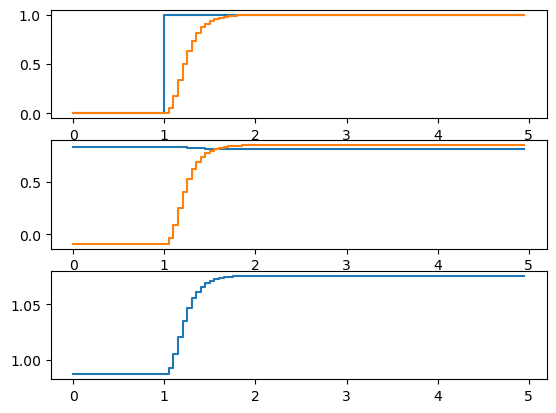

In [32]:
fig, axes = plt.subplots(nrows=3)
axes[0].step(times, outs[:,1])
axes[0].step(times, outs[:,2])

axes[1].step(times, outs[:,4])
axes[1].step(times, outs[:,5])

axes[2].step(times, outs[:,3])

In [24]:
q_s_LV0101

0.8099010543105805